In [1]:
from lienp.datasets.gpcurve import RBFCurve
from lienp.modules import LieConv
from lienp.liegroups import T
import matplotlib.pyplot as plt
import torch
from gpytorch.kernels import RBFKernel
from torch.utils.data import DataLoader

In [2]:
k = RBFKernel()
group = T(1)
r = 2
fill = 0.15
nbhd=5
dataset = RBFCurve(train=True, data_range=(-2, 2))
dl = DataLoader(dataset, batch_size=4)

In [3]:
(xc, yc), (xt, yt) = iter(dl).next()
mc = torch.ones(*xc.shape[:2], dtype=torch.bool)
mt = torch.ones(*xt.shape[:2], dtype=torch.bool)

/Users/makora/.pyenv/versions/miniconda3-latest/envs/liecnp/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


In [126]:
lic = group.lift((xc, yc, mc), 1)
lit = group.lift((xt, yt, mt), 1)
idx = torch.randint(0, 25, size=(2,)).unsqueeze(0)
B = torch.arange(4).long()[:, None]

In [127]:
lit[0].shape

torch.Size([4, 68, 68, 1])

In [251]:
ab_at_query = lit[0][B, idx]
mask_at_query = lit[2][B, idx]
dense = 1 / k(xt).evaluate().mean(-1)
dense = dense[B, idx]
dist_matrix = group.distance(ab_at_query)
within_ball = (dist_matrix < r) & lit[2][:, None, :] & mask_at_query[:, :, None]
valid_within_ball, nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), within_ball.sum(-1).max(), dim=-1, largest=True, sorted=False)
valid_within_ball = valid_within_ball > 1
current_fill = torch.sum(within_ball).float().div(mask_at_query.sum()).div(lit[2].sum())
print(r)

r += 0.5 * (fill - current_fill)
if r < 0: r = 0.001

tensor(0.2530)


In [210]:
d = group.distance(ab_at_query[B.reshape(-1, 1,1), torch.arange(2).reshape(1, -1, 1), nbhd_idx])

In [302]:
ab_at_query[B.reshape(-1, 1,1), torch.arange(2).reshape(1, -1, 1), nbhd_idx].shape

torch.Size([4, 2, 51, 1])

# ri = torch.randint(0, d.size(-1), size=d.shape[:2])
ti = ri % valid_within_ball.sum(-1)

In [273]:
dist_matrix[torch.arange(4).long().reshape(-1, 1, 1), torch.arange(2).long().reshape(1, -1, 1), torch.arange(68).long().reshape(1, 1, -1)].shape

torch.Size([4, 2, 68])

In [229]:
tmpidx = torch.cat([torch.zeros(1).long(), torch.ones(4, 10).bool().sum(-1).cumsum(0)[:-1]], 0)

In [246]:
ri, ti

(tensor([[10,  6],
         [42,  2],
         [39, 25],
         [31, 21]]), tensor([[10,  6],
         [42,  2],
         [39, 25],
         [31, 21]]))

In [295]:
ti + torch.cat([torch.zeros(4, 1).long(), valid_within_ball.sum(2).cumsum(1)[:, :-1]], 1)

tensor([[10, 56],
        [42, 51],
        [39, 76],
        [31, 53]])

In [298]:
fi = torch.where(valid_within_ball)[2][ti]

In [299]:
fi.shape

torch.Size([4, 2])

In [300]:
dist_matrix[torch.arange(4).long().reshape(-1, 1), torch.arange(2).long().reshape(1, -1), fi].shape

torch.Size([4, 2])

In [103]:
dist_matrix[torch.arange(4).reshape(-1, 1, 1), torch.arange(2).reshape(1, -1, 1), nbhd_idx]

tensor([[[0.3709, 0.2106, 0.0000, 0.1857, 0.2266, 0.3206, 0.2933, 0.0316,
          0.2047, 0.1330],
         [0.2814, 0.3131, 0.3153, 0.3947, 0.0000, 0.0491, 0.2344, 0.0204,
          0.4017, 0.0208]],

        [[0.4742, 0.4840, 0.3996, 0.0794, 0.5272, 0.2760, 0.4057, 0.5303,
          0.1281, 0.3684],
         [0.1388, 0.0845, 0.0120, 0.0149, 0.3178, 0.2244, 0.3510, 0.3538,
          0.0190, 0.2497]],

        [[0.0373, 0.1938, 0.1670, 0.0048, 0.1637, 0.0625, 0.0911, 0.0021,
          0.2697, 0.1973],
         [0.4801, 0.0996, 0.3859, 0.0143, 0.0602, 0.0326, 0.5606, 0.6058,
          0.4491, 0.1149]],

        [[0.2422, 0.0860, 0.2793, 0.1824, 0.2015, 0.1266, 0.1318, 0.2873,
          0.1079, 0.0000],
         [0.4389, 0.3443, 0.5418, 0.1314, 0.3037, 0.2154, 0.2542, 0.3473,
          0.5059, 0.1339]]])

In [37]:
mask_at_query[torch.arange(4).reshape(-1, 1), torch.arange(2).reshape(1, -1)].shape

torch.Size([4, 2])

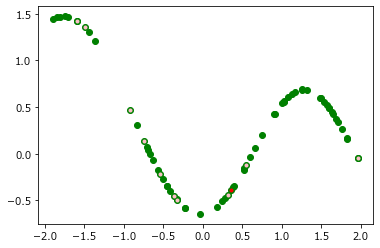

In [7]:
plt.plot(xt[0, :, 0], yt[0, :, 0], '.')
plt.plot(xt[0, :, 0][within_ball[0, 0]], yt[0, :, 0][within_ball[0, 0]], 'o', color='green')
plt.plot(xt[0, :, 0][nbhd_idx[0, 0]], yt[0, :, 0][nbhd_idx[0, 0]], '.', color='pink')
plt.plot(xt[0, :, 0][idx[0, 0]], yt[0, :, 0][idx[0, 0]], '.',  color='red')

In [8]:
within_ball.shape


torch.Size([4, 2, 68])

In [9]:
from lienp.modules.euclid_farthersubsample import _farthest_point_sample, square_distance

In [10]:
dist_matrix[torch.arange(4).reshape(-1, 1)].shape

torch.Size([4, 1, 2, 68])

In [11]:
ab_at_query[torch.arange(4).reshape(-1, 1, 1), torch.arange(2).reshape(1, -1, 1), nbhd_idx].shape

torch.Size([4, 2, 10, 1])

In [12]:
_farthest_point_sample(within_ball.float(), 5, square_distance)

tensor([[0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1]])

In [13]:
 farthest_indices = torch.randint(low=0, high=M, size=(B, N)).to(device)

NameError: name 'M' is not defined

In [14]:
def _farthest_point_sample(points, n_sample, distance):
    """Sampling farthest points from random point

    Args:
        points: point-cloud data index, (B, N, D)
        n_sample: number of samples

    Returns:
        centroids: sampled point-cloud data index, (B, n_sample)

    """
    B, N, D = points.shape
    device = points.device
    centroids = torch.zeros(B, N, n_sample).long().to(device)
    distances = torch.ones(B, N).to(device) * 1e8

    farthest_indices = torch.randint(low=0, high=N, size=(B,)).to(device)
    batch_indices = torch.arange(B).to(device)
    for i in range(n_sample):
        centroids[:, i] = farthest_indices
        centroid = points[batch_indices, farthest_indices, :].reshape(B, 1, D)
        dist = distance(points, centroid)  # [B, N, 1]
        mask = dist < distances
        distances[mask] = dist[mask]
        farthest_indices = distances.max(-1)[1]
    return centroids

In [319]:
data= torch.linspace(-2, 2, 20)
mask = torch.zeros(20)
mask[5:14] = 1.
mask = mask.bool()

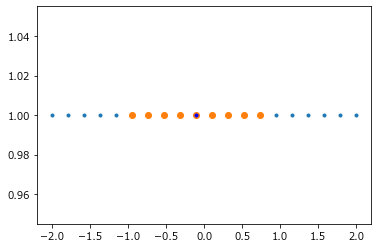

In [326]:
plt.plot(data, torch.ones_like(data), '.')
plt.plot(data[mask], torch.ones_like(data)[mask], 'o')
plt.plot(data[9], torch.ones(1), '.', color='blue')